# Fixed fares

Consider the following

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys

sys.path.append('/Users/haekim/dev/taxis-and-ubers/classes')
from data_cleaner import TaxiDataCleaner

custom_cmap = ListedColormap(['tomato', 'dodgerblue'])

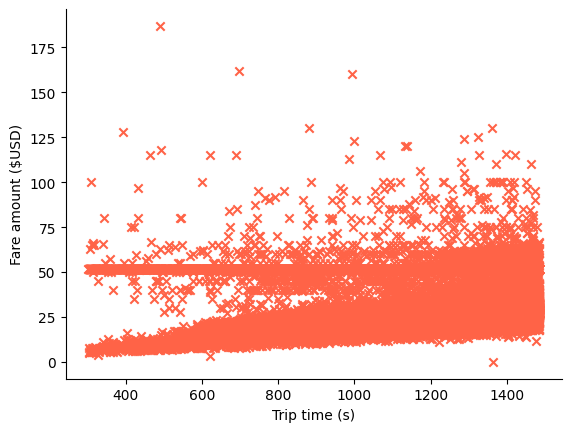

In [3]:
example_data = TaxiDataCleaner('/Users/haekim/dev/taxis-and-ubers/data/monthly_data/yellow_taxi_2020-01.parquet')
example_data.clean_data(False)
example_df = example_data.data

plt.scatter(example_df['trip_time_in_secs'], example_df['fare_amount'], marker='x', color='tomato')
plt.xlabel('Trip time (s)')
plt.ylabel('Fare amount ($USD)')
sns.despine()

You can see that there is a band of data ~50; which is likely airport trips and/or just fixed rate trips that people are taking.
> We must get rid of these bands if possible - as this is not significant to our analysis and will affect regression

Finding a fixed price is not effective - as across the years, the fixed rate from airports has of course changed with inflation and other factors. Rather, we attempt to cluster and remove these points.

We begin by trying to do $K = 2$ K-means clustering on the fare amount, to see whether we can get rid of that band

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = example_df[['fare_amount']]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
example_df['cluster_group'] = kmeans.labels_

Text(0.5, 1.0, 'Initial attempts at clustering to remove the fixed fare band remove fair data')

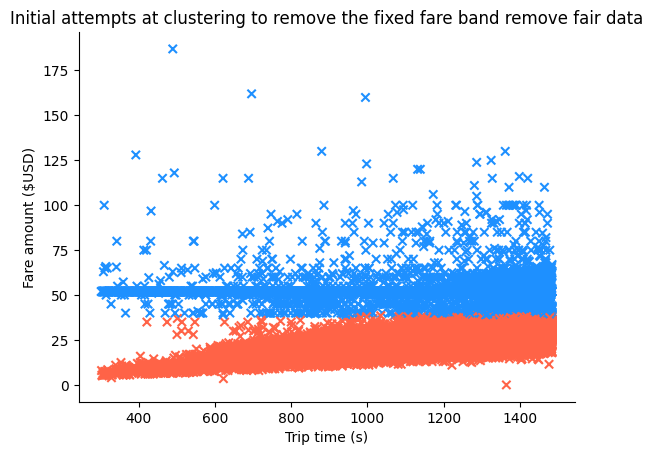

In [7]:
plt.scatter(example_df['trip_time_in_secs'], example_df['fare_amount'], marker='x', c=example_df['cluster_group'], cmap=custom_cmap)
sns.despine()
plt.ylabel('Fare amount ($USD)')
plt.xlabel('Trip time (s)')
plt.title('Initial attempts at clustering to remove the fixed fare band remove fair data')

We can, but we also do get rid of a part of data we actually want to preverse past ~1100 seconds.

A feature we could make is `fare per sec` - this would inflate the fix fare band and make it non-linear; whereas the 'fair' data would become hopefully constant or close-to constant.

Text(0, 0.5, 'Fare per sec')

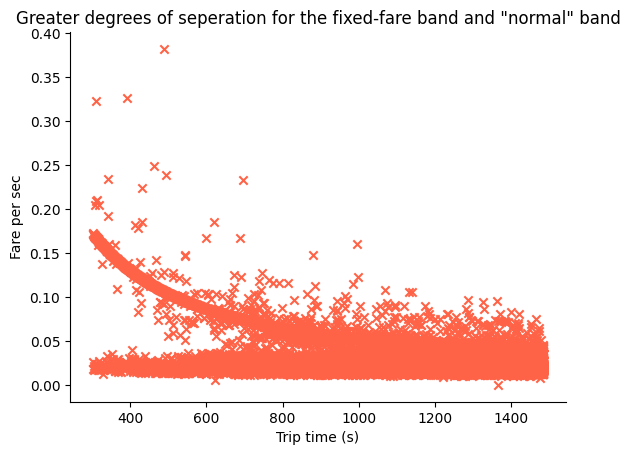

In [8]:
example_df['fare_per_sec'] = example_df['fare_amount'] / example_df['trip_time_in_secs']
plt.scatter(example_df['trip_time_in_secs'], example_df['fare_per_sec'], marker='x', color='tomato')
sns.despine()
plt.title('Greater degrees of seperation for the fixed-fare band and "normal" band')
plt.xlabel('Trip time (s)')
plt.ylabel('Fare per sec')

In [10]:
X = example_df[['fare_per_sec']]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

example_df['cluster_group_alt'] = kmeans.labels_

Text(0.5, 1.0, 'Clustering on fare per sec provides better clustering')

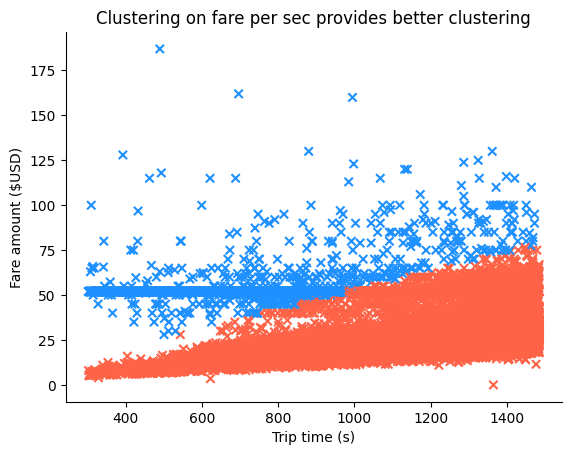

In [13]:
plt.scatter(example_df['trip_time_in_secs'], example_df['fare_amount'], marker='x', c=example_df['cluster_group_alt'], cmap=custom_cmap)
sns.despine()
plt.ylabel('Fare amount ($USD)')
plt.xlabel('Trip time (s)')
plt.title('Clustering on fare per sec provides better clustering')

This is clearly much more representative of the linear relationship we expect between trip time and fare amount.